In [2]:
#Se importan las librerias con las cuales se va a desarrollar el ejercicio

#Manejo de datos
import pandas as pd
import numpy as np
import os
import glob 
import openpyxl

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from xverse.transformer import WOE
from xverse.transformer import MonotonicBinning
from xverse.ensemble import VotingSelector
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Creación de funciones personalizadas

In [3]:
## Funciones para valores perdidos.

## Porcentaje de valores perdidos por variable
def resum_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
    return missing_data

## dataFrame de resumen de posición de valores perdidos.  
def posmissing(df):
    lista_miss = np.where(df.isna())
    v1 = pd.Series(np.ndarray.tolist(lista_miss[0]))
    v2 = pd.Series(np.ndarray.tolist(lista_miss[1]))
    resumen_vna = pd.concat([v1, v2], axis=1, keys=['posicion_fila', 'posicion_columna'])
    return resumen_vna

In [4]:
# Lee los nombres de archivos del directorio de trabajo
filenames = glob.glob('Datos/*.csv')

In [5]:
filenames

['Datos\\DatosNegativos1.csv', 'Datos\\DatosPositivos1.csv']

In [6]:
# Leemos y cargamos el contenido de los archivos .xlsx
df = pd.DataFrame()
for filename in filenames:
    data = pd.read_csv(filename)
    print(data.shape)
    df = df.append(data)

(5561, 1760)
(8322, 1761)


In [7]:
# Tamaño del set de datos completo
df.shape

(13883, 1761)

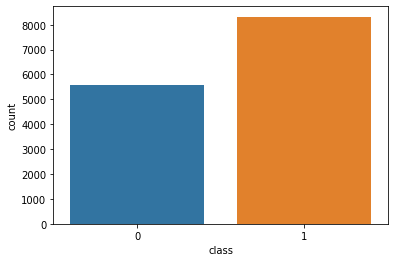

In [8]:
# Contamos los valores por clase, y vemos que la clase está desbalanceada
%matplotlib inline
sns.countplot(df["class"])

Dado que la variable objetivo está desbalanceada, es necesario aplicar un método de balanceo que nos permita tener las clases equilibradas.

In [9]:
# Eliminamos la columna que ennumera del primer archivo
df_dep = df.drop(columns="Unnamed: 0")

In [11]:
# Revisamos si existen registros duplicados
i = 0
for flag in df_dep.duplicated():
    if flag: i+=1
print("Hay ",i," registors duplicados")


Hay  13  registors duplicados


In [12]:
#Se procede a realizar el borrado de los registros duplicados
df_dep.drop_duplicates(inplace = True)

In [13]:
df_dep.shape

(13870, 1760)

In [14]:
df_dep.head()

,sequence,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,...,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99,class
0,MAATRNK,7,790.93,1.996,0.002524,11.000305,-1.014286,77.657143,0.000000,28.571429,...,0.320600,0.103820,-0.027083,0.252915,0.015264,-0.320885,-0.084070,0.017633,0.048197,0
1,MKMDGLR,7,850.06,0.996,0.001172,8.497986,-0.671429,82.657143,0.000000,55.714286,...,0.465724,-0.162389,-0.067384,0.217970,0.163187,-0.199716,-0.182897,0.005889,0.083639,0
2,MNIKHYQ,7,933.09,1.094,0.001172,8.365906,-1.285714,121.985714,0.142857,55.714286,...,0.079691,-0.089058,-0.164751,0.160001,0.059969,-0.176142,-0.083836,-0.075733,0.013590,0
3,LLWNSIP,7,842.00,-0.004,-0.000005,5.524963,0.757143,55.914286,0.142857,167.142857,...,0.145998,-0.054856,-0.318185,0.192412,-0.221162,-0.243470,-0.044887,-0.169481,0.157881,0
4,MHPHMSY,7,902.05,0.193,0.000214,6.688049,-0.900000,149.057143,0.142857,0.000000,...,0.215792,0.107407,0.015924,0.111517,-0.025620,-0.388453,-0.008939,-0.151773,0.077744,0


In [339]:
# Creamos una columna enumerando cada fila
#df_dep = df_dep.assign(num=[0 + i for i in range(len(df_dep))])[['num'] + df_dep.columns.tolist()]

In [15]:
df_dep.tail()

,sequence,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,...,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99,class
8317,ILPIIGKILSTIFGK,15,1613.04,1.995,0.001237,10.002747,1.413333,30.873333,0.066667,182.000000,...,0.434125,0.086208,-0.687611,0.073980,0.208663,-0.913782,-0.772072,-0.467112,0.048286,1
8318,YAGAVANDL,9,892.96,-1.004,-0.001124,3.799866,0.522222,25.766667,0.111111,108.888889,...,0.569835,0.000841,-0.218052,0.310862,0.156330,-0.704753,-0.328585,-0.110042,0.144094,1
8319,KKCFRWQWRMKKLGA,15,1966.43,5.927,0.003014,11.172302,-1.166667,36.200000,0.200000,32.666667,...,0.834855,-0.637061,-0.061575,0.375839,0.260569,-1.443030,-0.623450,-0.510046,-0.385037,1
8320,GWAGWLLSPRGSRPSWGP,18,1967.20,1.996,0.001015,12.000061,-0.616667,63.505556,0.166667,48.888889,...,1.342827,0.287493,-0.718676,0.617331,0.311718,-1.982013,-0.189731,-0.301922,-0.016178,1
8321,LRRLYKRVVKLWKRLFRQLRRPVR,24,3237.00,10.994,0.003396,12.480896,-0.858333,129.737500,0.125000,117.500000,...,1.762594,-0.313281,-0.492161,0.683355,0.062932,-2.395024,-0.718505,-0.298672,0.367209,1


In [341]:
# Guardamos las variables num y sequence
#df_1 = df_dep[["num", "sequence"]]
#df_1.tail()

In [16]:
# Eliminamos la variable sequence del dataframe depurado
df_dep.pop("sequence")
df_dep.head()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99,class
0,7,790.93,1.996,0.002524,11.000305,-1.014286,77.657143,0.000000,28.571429,3.387143,...,0.320600,0.103820,-0.027083,0.252915,0.015264,-0.320885,-0.084070,0.017633,0.048197,0
1,7,850.06,0.996,0.001172,8.497986,-0.671429,82.657143,0.000000,55.714286,2.661429,...,0.465724,-0.162389,-0.067384,0.217970,0.163187,-0.199716,-0.182897,0.005889,0.083639,0
2,7,933.09,1.094,0.001172,8.365906,-1.285714,121.985714,0.142857,55.714286,2.180000,...,0.079691,-0.089058,-0.164751,0.160001,0.059969,-0.176142,-0.083836,-0.075733,0.013590,0
3,7,842.00,-0.004,-0.000005,5.524963,0.757143,55.914286,0.142857,167.142857,-1.007143,...,0.145998,-0.054856,-0.318185,0.192412,-0.221162,-0.243470,-0.044887,-0.169481,0.157881,0
4,7,902.05,0.193,0.000214,6.688049,-0.900000,149.057143,0.142857,0.000000,1.165714,...,0.215792,0.107407,0.015924,0.111517,-0.025620,-0.388453,-0.008939,-0.151773,0.077744,0


In [17]:
# Asignamos la variable objetivo
y = df_dep.pop("class")

## 1- Clasificación sin selección

### 1.1 Normalización

Antes de realizar el particionamiento y balanceo de los datos y aplicar los algoritmos que vamos que trabajaremos para la solución de esta necesidad, es necesario realizar un proceso de normalización, el cual nos permita tener todas las variables en la misma escala.

In [18]:
# Normalizamos el set de datos
names = df_dep.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df_dep)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [19]:
# Imprimimos los ultimos registros
scaled_df.tail()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
13865,-0.488564,-0.642492,-0.020168,0.177404,0.514897,1.607718,-0.197489,-0.446817,1.928100,-1.585107,...,0.154258,-1.146725,1.024871,-0.436728,-1.071036,-0.373448,0.712924,-0.747520,-0.274897,-0.244406
13866,-1.297813,-1.522470,-1.023839,-1.504823,-1.843510,0.670606,-0.314021,-0.009531,0.405997,-0.743800,...,0.897168,-0.926150,0.734878,0.861445,-0.307774,-0.552598,0.973893,0.536071,0.864803,0.148027
13867,-0.488564,-0.210630,1.295748,1.443661,0.959576,-1.105467,-0.075938,0.865040,-1.180876,0.689560,...,1.079754,-0.495402,-1.432091,1.294052,-0.098409,-0.195757,0.052166,-0.317361,-0.411932,-2.019310
13868,-0.083939,-0.209689,-0.019834,0.019127,1.274300,-0.527075,0.547161,0.537076,-0.843145,-0.205060,...,-1.137867,0.330227,1.708642,-0.522612,0.679707,-0.020659,-0.620746,0.937958,0.252357,-0.508451
13869,0.725310,1.342078,2.991513,1.716009,1.457119,-0.781217,2.058540,0.127120,0.585272,1.573250,...,-0.020105,1.012492,-0.332200,0.103627,0.892447,-0.872327,-1.136383,-0.592482,0.262732,1.061913


### 1.2 Creación de particiones

Para el proceso de particionamiento de los datos, manejaremos el set de datos de entrenamiento con un 80% de los datos originales y utilizaremos un 20% para pruebas. Adicionalmente, vamos a utilzar un muestreo donde estratificaremos a partir de la variable objetivo para que al momento de hacer la división se mantenga la distribución de los datos

In [20]:
# Particionamos el set de datos
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = .2, random_state=42, stratify = y)
#X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = .2, random_state=42)

### 1.3 Balanceamos el set de datos

Para realizar el balanceo de los datos, utilizaremos la función SMOTE, la cual es una técnica que nos permitirá hacer un sobre muestreo de la clase minoritaria, en este caso la clase representada con "0", esta función hace parte de la libreria imblearn 

In [21]:
%%time
# Se balancean los datos de entrenamiento
sm = SMOTE(random_state=42)
sm_data_X,sm_data_y=sm.fit_sample(X_train, y_train)

Wall time: 1min 20s


In [22]:
## Convirtiendo en DataFrame
bal_data_X = pd.DataFrame(sm_data_X, columns=X_train.columns)
type(bal_data_X)

pandas.core.frame.DataFrame

In [23]:
bal_data_y = pd.Series(sm_data_y)
type(bal_data_y)

pandas.core.series.Series

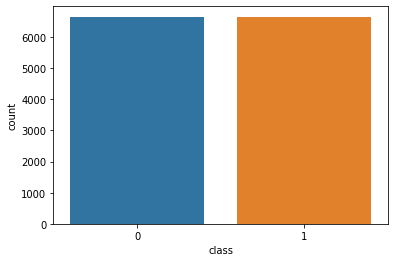

In [24]:
# Revisamos las clases
sns.countplot(bal_data_y)

Se observa que las clases ahora estan balanceadas, ahora podemos aplicar algoritmos de machine learning sin preocuparnos por la perdida de rendimiento a partir de desequilibrio de clases.

### Ahora, construiremos 3 clasificadores a partir de los datos preprocesados y revisaremos su rendimiento

### 1.3.1 Random Forest

In [25]:
# Entrenamos un modelo con Random Forest 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=0)
clf.fit(bal_data_X, bal_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [26]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(clf, bal_data_X, bal_data_y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.03)


In [27]:
# Hacemos predicciones con la data de prueba
predict = clf.predict(X_test)

In [28]:
predict

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

Text(33.0, 0.5, 'Real')

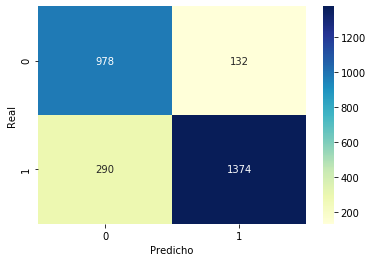

In [29]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(y_test, predict), annot=True, fmt='', cmap = 'YlGnBu')
bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicho')
plt.ylabel('Real')

In [30]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.77      0.88      0.82      1110
           1       0.91      0.83      0.87      1664

    accuracy                           0.85      2774
   macro avg       0.84      0.85      0.84      2774
weighted avg       0.86      0.85      0.85      2774



Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de buena forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene muy buena capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "0".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Se puede observar que lo hace mejor manera para la clase "0"

### 1.3.2 Redes Neuronales

In [31]:
# Entrenamos un modelo con Redes Neuronales
model = keras.Sequential([
    #keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    #keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [32]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
model.fit(bal_data_X, bal_data_y, epochs=5)

Train on 13316 samples
Epoch 1/5
13316/13316 [==============================] - 9s 708us/sample - loss: 0.3450 - acc: 0.8847
Epoch 2/5
13316/13316 [==============================] - 8s 569us/sample - loss: 0.1410 - acc: 0.9471
Epoch 3/5
13316/13316 [==============================] - 5s 413us/sample - loss: 0.1119 - acc: 0.9601
Epoch 4/5
13316/13316 [==============================] - 6s 468us/sample - loss: 0.0928 - acc: 0.9694
Epoch 5/5
13316/13316 [==============================] - 7s 553us/sample - loss: 0.0860 - acc: 0.9741


In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2774/2774 [==============================] - 0s 147us/sample - loss: 0.3455 - acc: 0.9023
Test accuracy: 0.90230715


In [35]:
# Hacemos predicciones con la data de prueba
predict = model.predict_classes(X_test)

In [ ]:
#from sklearn.model_selection import KFold
 
#n_split=3
 
#for train_index,test_index in KFold(n_split).split(bal_data_X, bal_data_y):
 # x_train,x_test = bal_data_X[train_index],bal_data_X[test_index]
  #y_train1,y_test1 = bal_data_y[train_index],bal_data_y[test_index]
  
  #model=create_model()
  #model.fit(x_train, y_train1, epochs=5)
  
  #print('Model evaluation ',model.evaluate(x_test,y_test1))

In [36]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[ 975,  135],
       [ 136, 1528]], dtype=int64)

In [37]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.88      0.88      0.88      1110
           1       0.92      0.92      0.92      1664

    accuracy                           0.90      2774
   macro avg       0.90      0.90      0.90      2774
weighted avg       0.90      0.90      0.90      2774



Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene una excelente capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "1".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

### 1.3.3 XG Boost

In [38]:
# Entrenamos un modelo con XG Boost
import xgboost as xgb
model=xgb.XGBClassifier(random_state=42,learning_rate=0.01, n_estimators = 5, max_depth=5)
model.fit(bal_data_X, bal_data_y)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [39]:
# Hacemos predicciones con la data de prueba
predict = model.predict(X_test)

In [40]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[ 988,  122],
       [ 197, 1467]], dtype=int64)

In [41]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(model, bal_data_X, bal_data_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 87.68% (2.09%)


In [42]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.83      0.89      0.86      1110
           1       0.92      0.88      0.90      1664

    accuracy                           0.89      2774
   macro avg       0.88      0.89      0.88      2774
weighted avg       0.89      0.89      0.89      2774



Interpretación de resultados

Se observa que el rendimiento del clasificador es del 100%, esto quiere decir que tenemos un caso de overfitting, donde el modelo ha aprendido todos los ejemplos de entrenamiento y donde no es buena la capacidad para generalizar. Es necesario revisar otro método.

### 1.3.4 Regresión Logística

In [43]:
# Entrenamos el modelo con regresión logística
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(bal_data_X, bal_data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
# Hacemos predicciones con la data de prueba
predict = lr.predict(X_test)

In [45]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[ 965,  145],
       [ 170, 1494]], dtype=int64)

In [46]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(lr, bal_data_X, bal_data_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 89.34% (3.54%)


In [47]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.85      0.87      0.86      1110
           1       0.91      0.90      0.90      1664

    accuracy                           0.89      2774
   macro avg       0.88      0.88      0.88      2774
weighted avg       0.89      0.89      0.89      2774



Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene una excelente capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "1".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

# 2- Clasificación con Selección

## 2.1.1 Selección de Variables

In [48]:
# Revisamos valores nulos
resum_missing(df_dep).head(10)

,Total,Porcentaje
embed_2_99,0,0.0
MoreauBrotoAuto_Hydrophobicity12,0,0.0
MoreauBrotoAuto_Hydrophobicity1,0,0.0
MoreauBrotoAuto_Hydrophobicity2,0,0.0
MoreauBrotoAuto_Hydrophobicity3,0,0.0
MoreauBrotoAuto_Hydrophobicity4,0,0.0
MoreauBrotoAuto_Hydrophobicity5,0,0.0
MoreauBrotoAuto_Hydrophobicity6,0,0.0
MoreauBrotoAuto_Hydrophobicity7,0,0.0
MoreauBrotoAuto_Hydrophobicity8,0,0.0


In [49]:
bal_data_X.describe()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
count,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,...,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000,13316.000000
mean,0.026237,0.023381,-0.059734,-0.069110,-0.045780,0.034864,-0.004872,-0.031195,0.007898,-0.015477,...,-0.033934,0.021948,0.012639,-0.030035,0.049797,-0.006662,-0.022909,-0.024890,-0.008622,0.018984
std,0.998034,1.002488,0.966308,0.963758,0.985143,0.985176,0.956383,0.954419,0.970408,0.975472,...,0.994299,0.999591,0.969523,0.984367,0.990358,0.970101,0.992850,0.985222,0.991810,0.974496
min,-1.702437,-1.972713,-5.337716,-6.288255,-2.100264,-4.484679,-2.539967,-1.102745,-1.860964,-2.992340,...,-5.540852,-2.119131,-6.029332,-4.655009,-4.450679,-3.043203,-4.020381,-4.909020,-5.052933,-6.317806
25%,-0.758313,-0.753727,-0.688836,-0.704914,-0.959414,-0.570892,-0.625438,-0.674966,-0.688524,-0.670763,...,-0.621550,-0.747660,-0.518865,-0.647932,-0.655701,-0.678335,-0.628274,-0.638322,-0.571536,-0.557394
50%,-0.083939,-0.105651,-0.177303,-0.155167,0.124857,0.041401,-0.159859,-0.208297,-0.048937,-0.064925,...,0.110542,-0.129177,0.102032,0.069869,-0.054613,-0.167819,0.125164,0.131906,0.140574,-0.004768
75%,0.725310,0.705879,0.447029,0.479057,0.695489,0.662260,0.397591,0.410936,0.634887,0.547931,...,0.686710,0.654293,0.624881,0.680281,0.645501,0.502635,0.743221,0.713489,0.695591,0.568997
max,2.208933,3.163712,6.673536,4.041338,1.776994,3.826847,10.206016,7.096358,4.580690,6.558402,...,3.252543,4.678685,5.180902,3.939679,5.591166,5.750887,1.905228,3.306232,3.398240,7.991585


### RFE Random Forest

### Buscamos las 100 variables mas importantes usando Random Forest

In [50]:
rf = RandomForestClassifier(n_estimators = 10, max_depth=5, random_state=42)
rf.fit(bal_data_X, bal_data_y)
mask = rf.feature_importances_ > .01
X_reduced = bal_data_X.loc[:, mask]
print(X_reduced.columns)

Index(['charge_density', 'E', 'M', '_SolventAccessibilityC3', '_ChargeC1',
       '_ChargeC2', '_HydrophobicityC2', '_PolarityT13',
       '_PolarizabilityD1025', '_PolarizabilityD2001', '_PolarizabilityD3001',
       '_SolventAccessibilityD1001', '_SolventAccessibilityD3075',
       '_SecondaryStrD1001', '_SecondaryStrD2025', '_SecondaryStrD3001',
       '_NormalizedVDWVD1001', '_NormalizedVDWVD2001', '_HydrophobicityD2001',
       '_HydrophobicityD3001', 'GearyAuto_FreeEnergy6',
       'GearyAuto_Mutability3', 'QSOgrant13', 'QSOSW12', 'QSOSW13', 'QSOSW27'],
      dtype='object')


In [ ]:
#%%time
#from sklearn.feature_selection import RFE
#rfe = RFE(estimator=RandomForestClassifier(n_estimators = 10, max_depth=5, random_state=42), n_features_to_select=100, verbose=0)
#rfe.fit(bal_data_X, bal_data_y)

In [49]:
#rfe_vals = bal_data_X.columns[rfe.support_]
#print("Las variables mas importantes son : ", rfe_vals)

## 2.1.2 Extracción de Variables

Usaremos PCA para encontrar los componentes que explican de mejor manera la varianza

In [51]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [52]:
print(pca.explained_variance_ratio_)

[1.20129778e-01 3.04775499e-02 2.52562426e-02 ... 1.16831565e-33
 1.16831565e-33 1.16831565e-33]


In [53]:
print(pca.explained_variance_ratio_.cumsum())

[0.12012978 0.15060733 0.17586357 ... 1.         1.         1.        ]


### Miramos el número de componentes que explican la varianza

In [54]:
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

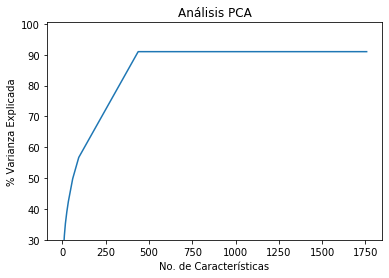

In [55]:
plt.ylabel('% Varianza Explicada')
plt.xlabel('No. de Características')
plt.title('Análisis PCA')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

## 2.1.3 Extracción de variables usando Peso de la Evidencia y valor de la información

Para encontrar las variables con las que entrenaremos los clasificaremos utilizaremos el Peso de la evidencia y valor de información asi como un sistema de recomendación a partir de modelos de machine learning. La idea es aplicar una variedad de técnicas para seleccionar variables. Cuando un algoritmo elige una variable, le damos un voto a la variable. Al final, calculamos los votos totales para cada variable y luego elegimos los mejores en función de los votos. De esta manera, terminamos eligiendo las mejores variables 

In [56]:
%%time
# Seleccionamos las variables mas importantes a partir de votos de modelos
vs = VotingSelector()
vs.fit(bal_data_X, bal_data_y)

Wall time: 40min 58s


VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=879,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [57]:
delta_crit = 4
priorizadas = vs.feature_votes_[vs.feature_votes_["Votes"]>delta_crit]["Variable_Name"].values
print("Estas son las variables más importantes, según el consenso de votos de selección,", \
      delta_crit+1," donde las columnas de interes son:",\
      priorizadas)

Estas son las variables más importantes, según el consenso de votos de selección, 5  donde las columnas de interes son: ['M' '_ChargeT13' 'GearyAuto_ResidueVol3' 'GearyAuto_ResidueVol10' 'H'
 'GearyAuto_Hydrophobicity15' 'GearyAuto_Hydrophobicity12' 'embed_1_57'
 'GearyAuto_AvFlexibility10' 'GearyAuto_FreeEnergy6' 'embed_0_57'
 '_NormalizedVDWVC3' '_PolarizabilityC3' 'GearyAuto_Hydrophobicity8'
 'GearyAuto_FreeEnergy5' 'embed_2_57' 'GearyAuto_FreeEnergy26' 'Y'
 '_SecondaryStrD2050' '_SecondaryStrD1050' 'molecular_weight' 'embed_1_40'
 'N' 'embed_0_34' 'embed_0_41' 'LL' '_SecondaryStrD2025' 'embed_1_94'
 'embed_2_40' 'MK' '_SecondaryStrD3050' '_HydrophobicityD2100' 'taugrant4'
 'tausw4' '_NormalizedVDWVD1100' 'GearyAuto_Steric12' 'embed_1_93'
 '_PolarizabilityD1025' 'embed_2_82' 'GearyAuto_FreeEnergy19' 'C'
 'QSOSW19' 'MoreauBrotoAuto_Mutability5' 'QSOgrant19' 'embed_2_49'
 '_PolarityD2025' '_HydrophobicityD3025' 'GearyAuto_ResidueVol11'
 'QSOgrant7' 'GearyAuto_FreeEnergy1' 'embed_1_47'

## 2.2 Entrenar con las caracteristicas seleccionadas

### Cargamos la data de validación

In [58]:
val_data = pd.read_csv('Datos/val/DatosValidacion1.csv')
val_data.pop("Unnamed: 0")
val_data.pop("Unnamed: 0.1")
val_data.pop("sequence")
y2 = val_data.pop("class")
# Creamos una columna enumerando cada fila
#val_data = val_data.assign(num=[0 + i for i in range(len(val_data))])[['num'] + val_data.columns.tolist()]
val_data.head()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,33,3897.77,8.691,0.002230,11.404358,-0.112121,84.766667,0.030303,85.757576,3.333939,...,-0.928374,2.771416,-0.851930,-0.459909,0.909622,1.402783,-3.848056,-0.528822,-0.740751,-0.257650
1,34,4003.64,7.590,0.001896,10.196106,-0.638235,76.035294,0.117647,34.411765,3.875588,...,-1.030314,2.356963,-0.590644,-0.433246,0.362768,1.204798,-3.838024,-0.859893,-1.086264,0.052278
2,35,4121.92,6.689,0.001623,9.611023,-0.551429,16.851429,0.057143,64.000000,3.107429,...,-0.846578,2.762231,-1.182640,-0.908285,0.802487,1.546229,-4.543212,-0.786475,-0.477468,-0.178319
3,31,3838.56,6.589,0.001717,9.802917,-0.200000,53.977419,0.161290,47.096774,3.012581,...,-0.960986,1.742604,-0.981736,-0.098695,0.614634,0.774174,-2.818301,-0.395545,-0.738405,0.369630
4,33,3715.45,3.591,0.000967,8.981384,0.660606,62.042424,0.090909,91.212121,1.404848,...,-1.034936,1.734715,-0.830263,-0.386610,0.836167,0.859871,-3.665342,-0.922017,-0.364447,-0.055827


In [59]:
# Normalizamos el set de datos de validación
names = val_data.columns
scaler = preprocessing.StandardScaler()
scaled_val_data = scaler.fit_transform(val_data)
scaled_val_data  = pd.DataFrame(scaled_val_data, columns=names)
scaled_val_data.head()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,1.200441,1.488957,2.993163,2.041380,1.680420,0.057637,1.795329,-0.751363,-0.178559,1.487591,...,-0.709365,1.945619,-1.703364,0.675871,1.054814,3.373537,-2.357323,0.456880,-0.985170,-1.610517
1,1.346667,1.627166,2.600490,1.720552,1.201197,-0.688985,1.474132,0.681090,-1.690778,1.908721,...,-0.996886,1.241833,-0.840013,0.748034,-0.608378,2.709067,-2.344236,-0.497817,-2.046474,-0.469698
2,1.492893,1.781575,2.279148,1.458301,0.969138,-0.565795,-0.703036,-0.311187,-0.819356,1.311480,...,-0.478661,1.930022,-2.796106,-0.537628,0.728976,3.854966,-3.264137,-0.286104,-0.176447,-1.318507
3,0.907989,1.411661,2.243483,1.548356,1.045248,-0.067074,0.662700,1.396846,-1.317184,1.237736,...,-0.801345,0.198585,-2.132271,1.653474,0.157642,1.263816,-1.014032,0.841203,-0.977964,0.698452
4,1.200441,1.250947,1.174245,0.827828,0.719407,1.154235,0.959383,0.242584,-0.017914,-0.012268,...,-1.009921,0.185188,-1.631771,0.874250,0.831410,1.551430,-2.118977,-0.676961,0.170717,-0.867622


In [60]:
data_val_x = scaled_val_data

## 2.2.1 Random Forest (Validación)

In [121]:
%%time
# Entrenamos un modelo con Random Forest 
rf1=RandomForestClassifier(random_state=42, max_features=.025, n_estimators= 8000, max_depth=1.9, criterion='gini', min_samples_split = 16,min_samples_leaf = 3, oob_score = True)
rf1.fit(bal_data_X[priorizadas], bal_data_y)
# Hacemos predicciones con la data de prueba
predict1 = rf1.predict(data_val_x[priorizadas])

precision    recall  f1-score   support

           0       0.96      0.72      0.82      1354
           1       0.37      0.86      0.52       269

    accuracy                           0.74      1623
   macro avg       0.67      0.79      0.67      1623
weighted avg       0.86      0.74      0.77      1623

Wall time: 2min 7s


Text(33.0, 0.5, 'Real')

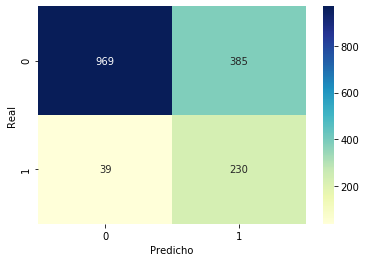

In [122]:
# Revisamos la matriz de confusión
ax = sns.heatmap(confusion_matrix(y2, predict1), annot=True, fmt='', cmap = 'YlGnBu')
bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicho')
plt.ylabel('Real')


In [123]:
print(classification_report(y2, predict1))

precision    recall  f1-score   support

           0       0.96      0.72      0.82      1354
           1       0.37      0.86      0.52       269

    accuracy                           0.74      1623
   macro avg       0.67      0.79      0.67      1623
weighted avg       0.86      0.74      0.77      1623



In [124]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y2, predict1)

0.3765959875419209

In [125]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y2, predict1)

0.7853379495148617

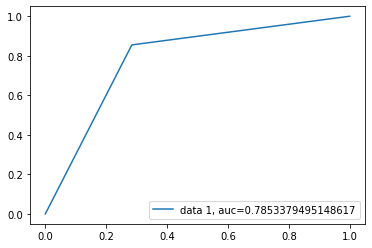

In [126]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y2, predict1)
auc = metrics.roc_auc_score(y2, predict1)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() 

## 2.2.2 XG Boost (Validación)

In [196]:
xgb_clf = xgb.XGBClassifier(random_state=42,learning_rate=0.005, n_estimators = 1000, max_depth=2, min_samples_split = 16,min_samples_leaf = 3)
xgb_clf.fit(bal_data_X[priorizadas], bal_data_y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=2,
              min_child_weight=1, min_samples_leaf=3, min_samples_split=16,
              missing=nan, monotone_constraints=None, n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [197]:
predict2 = xgb_clf.predict(data_val_x[priorizadas])
print(classification_report(y2, predict2))

precision    recall  f1-score   support

           0       0.96      0.69      0.80      1354
           1       0.35      0.85      0.50       269

    accuracy                           0.72      1623
   macro avg       0.65      0.77      0.65      1623
weighted avg       0.86      0.72      0.75      1623



In [198]:
cohen_kappa_score(y2, predict2)

0.3426914877203808

In [199]:
roc_auc_score(y2, predict2)

0.7683265335258879

In [131]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y2, predict2)

array([[797, 557],
       [149, 120]], dtype=int64)

In [132]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y2, predict2))

precision    recall  f1-score   support

           0       0.84      0.59      0.69      1354
           1       0.18      0.45      0.25       269

    accuracy                           0.57      1623
   macro avg       0.51      0.52      0.47      1623
weighted avg       0.73      0.57      0.62      1623



In [216]:
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=.025, max_depth=2, random_state=42)
    gb_clf.fit(bal_data_X[priorizadas], bal_data_y)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(bal_data_X[priorizadas], bal_data_y)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(data_val_x[priorizadas], y2)))

Learning rate:  0.05
Accuracy score (training): 0.886
Accuracy score (validation): 0.661
Learning rate:  0.075
Accuracy score (training): 0.897
Accuracy score (validation): 0.674
Learning rate:  0.1
Accuracy score (training): 0.905
Accuracy score (validation): 0.664
Learning rate:  0.25
Accuracy score (training): 0.925
Accuracy score (validation): 0.654
Learning rate:  0.5
Accuracy score (training): 0.937
Accuracy score (validation): 0.593
Learning rate:  0.75
Accuracy score (training): 0.945
Accuracy score (validation): 0.536
Learning rate:  1
Accuracy score (training): 0.947
Accuracy score (validation): 0.770


In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_features=.025, max_depth=2, random_state=42)
    gb_clf.fit(bal_data_X[priorizadas], bal_data_y)

In [218]:
predict2 = gb_clf.predict(data_val_x[priorizadas])
print(classification_report(y2, predict2))

precision    recall  f1-score   support

           0       0.95      0.77      0.85      1354
           1       0.40      0.79      0.53       269

    accuracy                           0.77      1623
   macro avg       0.67      0.78      0.69      1623
weighted avg       0.86      0.77      0.79      1623



In [219]:
cohen_kappa_score(y2, predict2)

0.3993362043714723

In [220]:
roc_auc_score(y2, predict2)

0.776991483309813

## 2.2.3 Regresión Logística (Validación)

In [ ]:
lr = LogisticRegression()
lr.fit(bal_data_X[priorizadas], bal_data_y)

In [ ]:
predict = lr.predict(X_test[priorizadas])

In [ ]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

In [ ]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))